# Exploring some LOFAR data in Jupyter notebook

In this notebook we will be exploring some LOFAR data. LOFAR is a radio interferometer, i.e. all stations record the signal from a given direction and from the interference of that signal an image can be produced.

There are a few things for which the instruments needs to be calibrated. That is done by pointing the telescope at a well-known source (in this case 3C196) and comparing the measured data with the expected data.

We will explore some calibration solutions, which are stored in an HDF5 file.

## Initialize and check environment

In [163]:
import sys

In [ ]:
sys.executable

The above line should mention that you're running python from the `school18` environment

## Download and view the calibration solution file

The calibration solutions are stored in HDF5 files. Please download the file `lofar-cal.h5` from the school2018-extra repository. No need to clone, the following command should do the trick:

In [ ]:
!pwd
# Uncomment the line below if you realize this is going to download 52 MB
#!wget https://github.com/Asterics2020-Obelics/School2018-extra/raw/master/lofar-cal.h5

In [ ]:
import h5py

In [ ]:
h5py.__file__

The above line should mention that you're running the `h5py` from the `school2018` environment

In [14]:
import numpy as np

Let's open the HDF5 file with LOFAR calibration solutions (change the path to the place where the file is).

In [15]:
h5filename = 'lofar-cal.h5'

In [6]:
h5file = h5py.File(h5filename, mode='r')

The HDF5 format is hierarchical, it's basically a tree. To show all objects, there is a function `visit`.

**Exercise**: show the docstring for the `visit` method.

**Bonus exercise** 😉: If you want to practice git, fix the typo in `guranteed` and open a pull request at https://github.com/h5py/h5py (first check if no one else did it yet).

**Exercise**: use the `visit` function of `h5file` to show the contents of the solutions file.

In [ ]:
h5file.visit(print)

This would look much more like a tree if it had some indentation at the right places.

**Exercise**: Create a function `print_node` which, given a node, prints the last component of the string representation of the node, indented by depth in the tree (level 1 gets 4 spaces indent, level 2 gets 8, etc.). Use this function with "`visit`" from `h5py.File` to get the following output:
```
sol000
  amplitude000
    ant
    freq
    pol
    time
    val
  antenna
  phase000
    ant
    freq
    pol
    time
    val
  source
```

In [ ]:
h5file.visit(print_node)

**Exercise**: expand the function `print_node` to take an optional parameter `indent` which specifies the number of spaces to use for indentation.

**Exercise**: create the function `print_h5(file, *, indent=4)` which uses `visit` and the function `print_node` to print a listing of an HDF5 file.

**Hint**: You may need to use a lambda function `lambda node: print_node(node, indent=indent)` to pass the `indent` argument.

## Excursion to PyCharm

1. Copy the functions `print_node` and `print_h5` to a new python file `print_h5.py` and open it in PyCharm.
2. Make all PyCharm warnings go away; make sure that running `pycodestyle print_h5.py` creates no warnings.
3. Make this file executable, use the `#!/usr/bin/env python` as first line.
4. Use `if __name == "__main__"` to make it possible to run the file both as an importable module and as a stand-alone file.
5. Use argparse to create an interface like the following:

```
./print_h5.py --help
usage: print_h5.py [-h] [-i INDENT] filename

Print contents of an HDF5 file.

positional arguments:
  filename              HDF5 file name

optional arguments:
  -h, --help            show this help message and exit
  -i INDENT, --indent INDENT
                        Indentation level
```
6. Include doctests in your function `print_node` to verify that:

```
a/b/c prints '        c'
a/b prints   '    b'
a prints     'a'

a/b with indent = 2 prints '  a'
```
7. In a terminal, run `pytest --doctest-modules print_h5.py` and check that the doctests run and pass.

## Continue after PyCharm excursion

If the file `print_h5.py` is in the current working directory, we can load it into this notebook:

In [8]:
from print_h5 import print_h5

In [9]:
print_h5(h5filename)

sol000
    amplitude000
        ant
        freq
        pol
        time
        val
    antenna
    phase000
        ant
        freq
        pol
        time
        val
    source


All solutions are stored inside the group '`sol000`'.

A few words about the file format:
 * The `antenna` table contains metadata on the antennas (or actually antenna stations)
 * The tables `amplitude000/val` and `phase000/val` contain the actual calibration data, in a large cube (multi-dimensional array)
 * The other tables `amplitude/time`, `amplitude/ant`, `amplitude/freq`, , `amplitude/pol` contain the metadata for each of the axes of the data cube

You can access subgroups either by nesting squared brackets (i.e. `sol['amplitude000']['ant']`) or by using a slash (i.e. `sol['amplitude000/ant']`).

## Plot antennas

In [10]:
antennadata = h5file['sol000/antenna']

In [11]:
antennadata[0]

(b'CS001LBA', [ 6.8676305, 52.911396 , 50.16268  ])

An antenna consists of a tuple of its name and its coordinates (in the form longitude, latitude and elevatiom).

Note that the name `b'CS001LBA'` comes from the HDF5 as "bytes": python does not know yet which character set to use for these bytes. To convert it to a normal string, we need to tell python the character set used. Actually any character set will do here, since (almost) all character sets map 'normal' letters to the right thing (and LOFAR does not have stations called `CS00😇LBA`).

In [12]:
antenna_names = [antenna[0].decode('utf-8') for antenna in antennadata]

In [16]:
coords_latlon = np.array([antenna[1][1::-1] for antenna in antennadata])

With `folium` we can convert this list of coordinates into a nice leaflet map.

In [17]:
import folium

In [18]:
antennamap = folium.Map(location=[52.91494834, 6.86876941], zoom_start=16,
                        tiles='http://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/MapServer/tile/{z}/{y}/{x}',
                        attr='ESRI')

for ant_num, coord_latlon in enumerate(coords_latlon):
    folium.Marker(coord_latlon, popup=antenna_names[ant_num]).add_to(antennamap)

In [43]:
antennamap

**Exercise**: Please explore this map a bit and appreciate the extent of LOFAR :)

## View a solution

Let's explore the solutions a bit.

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
amplitude_sol = h5file['sol000/amplitude000']

In [22]:
amplitude_sol.visit(print)

ant
freq
pol
time
val


The actual calibration values are stored in the node "`val`":

In [23]:
amplitude_sol['val']

<HDF5 dataset "val": shape (3, 35, 488, 2), type "<f8">

### Loading in data properly

Let's now close the HDF5 file and load the data more properly. Keeping it open all the time can have disadvantages e.g. when the kernel crashes.

In [ ]:
h5file.close()
del h5file, amplitude_sol

Let's create a function `load_solution(h5filename, solution_name)` that extracts a data cube (no metadata yet) from the HDF5 file and returns a numpy array. To avoid not closing the file when an exception happens, we use the construct "`with h5py.File(...) as h5file`".

In [1]:
def load_solution(h5filename, solution_name):
    with h5py.File(h5filename) as h5file:
        result = h5file['sol000/{}/val'.format(solution_name)].value
    return result

In [25]:
amplitude_values = load_solution(h5filename, "amplitude000")

In [26]:
amplitude_values.shape

(3, 35, 488, 2)

The axes of the data cube are, in order:
 * time: The time of the calibration, typically every 4 seconds
 * ant: Station name
 * freq: Frequency (in Hz)
 * pol: Polarization (linear, X or Y)

In [27]:
n_times, n_stations, n_freq, n_pol = amplitude_values.shape

Let's define another function `load_meta(h5filename, solution_name)` that returns a tuple of numpy arrays, i.e. `time, ant, freq, pol`, from the corresponding node in `h5file/sol000/solution_name/xxx`.

In [28]:
def load_axes(h5filename, solution_name):
    with h5py.File(h5filename) as h5file:
        result = [h5file['sol000/{}/{}'.format(solution_name, axis_name)].value for axis_name in ['time', 'ant', 'freq', 'pol']]
    return result

In [29]:
time_axis, station_axis, freq_axis, pol_axis = load_axes(h5filename, "amplitude000")

**Exercise**: Using the knowledge that the time axis is in seconds, how much time does the calibration span? (A typical observation lasts 8 hours.)

Let's plot the bandpass of some station:

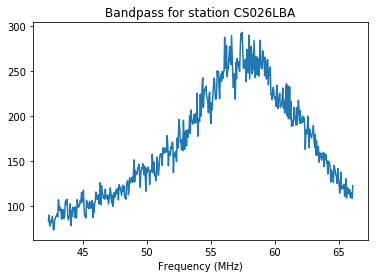

In [35]:
station_nr = 12
fig, ax = plt.subplots(1)
ax.plot(1.e-6 * freq_axis, amplitude_values[0, station_nr, :, 0])
ax.set_xlabel("Frequency (MHz)")
ax.set_title("Bandpass for station {station:}".format(
    station=station_axis[station_nr].decode('utf-8')));
del station_nr

In [36]:
del time_axis, station_axis, freq_axis, pol_axis, antenna_names, n_freq, n_pol, n_stations, n_times

## Class

The concept of a solution with different axes (each with their own metadata) is actually worth its own class. Let's create a class `Solution` with attributes `val`, `time`, `station`, `freq`, `pol`.

In [37]:
class Solution:
    def __init__(self, h5filename, solution_name):
        """Calibration solution extracted from HDF5 file
        
        Args:
            h5filename (str): filename (should be absolute)
            solution_name (str): name of solution, e.g. amplitude000
        
        Attributes:
            val (ndarray): data cube
            time (ndarray): time values in MJD seconds
            station (List[str]): station names
            freq (ndarray): frequency values in Hz
            pol (ndarray): polarization values
            station_number (Dict[str, int]): dict mapping station names to numbers
            
        """
        with h5py.File(h5filename) as h5file:
            self.val = h5file['sol000/{}/val'.format(solution_name)].value
            (self.time, self.station, self.freq, self.pol) = \
                 [h5file['sol000/{}/{}'.format(solution_name, axis_name)].value \
                  for axis_name in ['time', 'ant', 'freq', 'pol']]
            self.station = list(self.station.astype('|U8'))
            
            self.station_number = {self.station[station_num]: station_num
                  for station_num in range(len(self.station))}

**Exercise**: use this class to get a solution for `amplitude000`.

## Make the bandpass plot interactive

In [39]:
from ipywidgets import interactive, interact, fixed

In [40]:
amplitude_solution = Solution(h5filename, "amplitude000")

We'll use a dict "`station_number`" with the station names as key and their index in the array as values.

**Exercise**: create a function `plot_bandpass(solution, time, station_name, pol)` that creates the right bandpass plot.

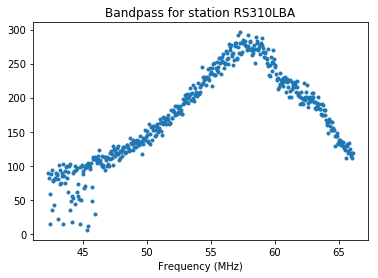

In [42]:
plot_bandpass(amplitude_solution, 2, 'RS310LBA', 0)

**Exercise**: create an interactive widget for the bandpass plot that shows a dropdown for the station name, a slider for the time and a dropdown for the polarization. For the `solution` parameter, you'll want to use `fixed` to indicate that this parameter does not need a widget.

In [ ]:
interactive(plot_bandpass,
            solution=fixed(amplitude_solution),
            station_name=amplitude_solution.station,
            time=(0, len(amplitude_solution.time)-1),
            pol=[0,1])

## Read in phase values

In [ ]:
phase_solution = Solution(h5filename, 'phase000')

In [ ]:
phase_values = phase_solution.val

In [ ]:
phase_solution.val.shape

In [ ]:
n_times, n_stations, n_freq, n_pol = phase_solution.val.shape

The phases are only meaningful when a phase reference is chosen; let's choose the first station as the phase reference.

In [ ]:
phase_values = phase_values[:, :, :, :] - phase_values[:, 0, :, :][:, np.newaxis, :, :]

For some physical reasons, the phase solutions for these calibration values wrap at $\pi$ (not $2\pi$ as all other phases do). We constrain all values between $-\pi/2$ and $\pi/2$.

In [ ]:
def constrain_pi(a):
    """Constrain numbers between -pi/2 and pi/2"""
    return np.mod(a + np.pi/2, np.pi) - np.pi/2

In [ ]:
phase_values = constrain_pi(phase_values)

**Exercise**: make a wrapper for the function `np.unwrap` that unwraps at $\pi$.

**Hint**: multiply the input, divide after constraining; use `**kwargs` to pass on optional arguments

In [ ]:
def plot_phase_freq(station_name, time=0, pol=0, unwrap=False):
    fig, ax = plt.subplots(1)
    phases = phase_values[time, phase_solution.station_number[station_name], :, pol]
    if unwrap:
        phases = unwrap_pi(phases)
    ax.plot(1.e-6 * phase_solution.freq, phases, '.')
    ax.set_xlabel("Frequency (MHz)")
    if not unwrap:
        ax.set_ylim(-np.pi/2, np.pi/2)
    ax.set_title("Phase for station {}".format(station_name))
    return ax

In [ ]:
interactive(plot_phase_freq, station_name=phase_solution.station,
            time=(0,n_times-1), pol=(0,1))

**Exercise**: look at the plots, see if you can see any trends (hint: look one cell below).

## Fitting a line

You should see some clear linear trends in the solutions; at least towards the higher numbered stations.

In [ ]:
time = 0
station = 17 # CS103LBA
pol = 0
np.polyfit(phase_solution.freq, unwrap_pi(phase_values[time, station, :, pol]), 1)

In [ ]:
del pol, time, station

We want to compute this fit for all timeslots, stations and polarizations. Ideally, without writing a loop like
```python
for timeslot in range(num_timeslots):
    for station in range(num_stations):
        for polarization in range(2):
            np.polyfit(sol['phase000/freq'], phase_values[timeslot, station, :, polarization], 1)
```
The common way to solve this, is to have numpy broadast an operation over other axes (apply an operation on one axis, and leave all other axes in place). This can usually be done with the argument `axis`. E.g. `np.mean(x, axis=(1,)` takes the mean over the second axis, leaving all other axes in place. Unfortunately, np.polyfit does not broadcast over axes.

We'll implement the [linear fit](https://en.wikipedia.org/wiki/Linear_regression) ourselves. This involves solving the equation $(\mathbf{X}^T.\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$, where $\mathbf{X}$ is a (tall) 2 by `n_freq` matrix containing a column of ones and a column with all frequencies, and $\mathbf{y}$ is a (tall) vector of length `n_freq` containing the measured phases.

In [ ]:
X = np.ones((n_freq, 2))
X[:, 1] = phase_solution.freq

Let's just write out the matrix, using the python 3 matrix multiplication operator `@` (for numpy arrays, this just calls `np.matmul` which mostly acts like `np.dot`).

In [ ]:
np.linalg.inv(X.T @ X) @ X.T @ unwrap_pi(phase_values[0, 17, :, 0])

Yay, this gives the same answer as `np.polyfit` (though in a different order).

Now to compute the fit for all stations, times and both polarizations at the same time, we use `np.tensordot`, which computes the dot product along two given axes and leaves all of the other axes in place. We need to "dot" the second axis (i.e. axis `1`) of `X` with the third axis (i.e. axis `2`) of the `phase_values`. All other axes remain.

In [ ]:
fit = np.tensordot(
    np.linalg.inv(X.T @ X),
    np.tensordot(X.T, unwrap_pi(phase_values[:, :, :, :], axis=2), axes=((1,), (2,))),
    axes=((1,),(0,))
)

In [ ]:
def fit_clock(freq, data, axis=-1):
    """Fit a0 + a1*freq through the data along the given axis"""
    
    assert len(freq) == data.shape[axis]
    
    X = np.ones((len(freq), 2)) # 2 for number of unknowns (a0 and a1)
    X[:, 1] = freq

    return np.tensordot(
        np.linalg.inv(X.T @ X),
        np.tensordot(X.T, data, axes=((1,), (axis,))),
        axes=((1,),(0,))
    )

In [ ]:
fit = fit_clock(phase_solution.freq, unwrap_pi(phase_values[:, :, :, :], axis=2), axis=2)

In [ ]:
fit.shape

The array `fit` has now dimensions `(num_params, n_times, n_stations, n_pol)`, where `n_params` is three (constant, linear term and 1/freq term).

Let's check that for the one check station it still gives the same answer:

In [ ]:
fit[:, 0, 14, 0]

## Plot the fitted lines

In [ ]:
def plot_phase_and_fit_freq(station_name, *, time=0, pol=0, unwrap=False):
    ax = plot_phase_freq(station_name, time, pol, unwrap)
    (intercept, slope) = fit[:, time, phase_solution.station_number[station_name], pol]
    fit_line = intercept + slope * phase_solution.freq
    if not unwrap:
        fit_line = constrain_pi(fit_line)
    ax.plot(1.e-6 * phase_solution.freq, fit_line)
    return ax

In [ ]:
interactive(plot_phase_and_fit_freq, station_name=phase_solution.station, time=(0, n_times-1), pol=(0,1))

**Exercise**: check the residual of the fit against the station number. Are we missing systematics?

**Exercise**: update the map above to include only stations that are part of `phase_solution`.

**Bigger exercise**: for the further away remote stations, it is clear that a higher-order term is missing. Physically, we expect to see a 1/freq term due to the ionosphere. Add a 1/freq term in the fit.

In [ ]:
def plot_phase_and_fit_freq2(station_name, *, time=0, pol=0, unwrap=False):
    ax = plot_phase_freq(station_name, time, pol, unwrap)
    (intercept, slope, tec) = fit2[:, time, phase_solution.station_number[station_name], pol]
    fit_line = intercept + slope * phase_solution.freq + tec / phase_solution.freq
    if not unwrap:
        fit_line = constrain_pi(fit_line)
    ax.plot(1.e-6 * phase_solution.freq, fit_line)
    return ax

In [ ]:
interactive(plot_phase_and_fit_freq2, station_name=phase_solution.station, time=(0, n_times-1), pol=(0,1))

**Exercise**: check the 1/freq term against station number; we expect to see higher values for this term for further away (i.e. higher-numbered) stations as they see through a different part of the ionosphere.

Now that we have a reasonable fit, we expect that the slope term represents a physical thing, namely the drift of the different clocks used in the various LOFAR stations. We can check that by plotting the delay (slope) term against time:

In [ ]:
def plot_delay_time(station_name, pol=0):
    fig, ax = plt.subplots(1)
    delays = (fit2[1, :, phase_solution.station_number[station_name], pol] -
              np.mean(fit[1, :, phase_solution.station_number[station_name], pol])) / (2*np.pi) * 1.e9
    ax.plot(phase_solution.time - phase_solution.time[0], delays, '.')
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Delay (ns)")
    ax.set_ylim(-10, 10)
    ax.set_title("Delay {}".format(station_name))
    return ax

In [ ]:
interactive(plot_delay_time, station_name=phase_solution.station, pol=[0,1])

**Exercise**: There are some systematics left; in particular try to plot the residual solutions (what's left after subtracting the fit) in one plot. (You're on your own from now on.)

## Acknowledgements
![](./eu_asterics.png)

This tutorial was supported by the H2020-Astronomy ESFRI and Research Infrastructure Cluster (Grant Agreement number: 653477).